In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import yfinance as yf
from tqdm import tqdm
from bisect import bisect_left

from arch import arch_model
from scipy.optimize import minimize
from scipy.spatial import ConvexHull
from scipy.interpolate import interp1d

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error
from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam

import random
from collections import deque


# Initial Markowitz model 


In [5]:
# We use the stocks of the DJI index 
tickers = [
    'MMM', 'AXP', 'AMGN', 'AAPL', 'BA', 'CAT', 'CVX', 'CSCO', 'DOW',
    'GS', 'HD', 'HON', 'IBM', 'INTC', 'JNJ', 'JPM', 'MCD', 'MRK', 'MSFT',
    'NKE', 'PFE', 'PG', 'CRM', 'TRV', 'UNH', 'VZ', 'WMT', 'DIS'
]


# Download full dataset
full_data = yf.download(tickers, start="2005-01-01", end="2025-01-01")["Close"]
full_data = full_data.dropna(axis=1)  # Remove stocks with incomplete data
tickers = full_data.columns.tolist()  # Update tickers

# Split data into training (pre-2015) and testing (2015–2024)
train_data = full_data.loc[:'2019-12-31']
test_data = full_data.loc['2020-01-01':]

# Step 3: Compute returns
returns = full_data.pct_change().dropna()
train_returns = train_data.pct_change().dropna()
test_returns = test_data.pct_change().dropna()

# Calculate mean returns and covariance from training data
mean_train_returns = train_returns.mean() * 252
cov_train_matrix = train_returns.cov() * 252



[*********************100%***********************]  28 of 28 completed


In [6]:
# Define helper functions

def portfolio_return(weights, mean_returns):
    return np.sum(weights * mean_returns)

def portfolio_volatility(weights, cov_matrix):
    return np.sqrt(np.dot(weights.T, np.dot(cov_matrix, weights)))

def constraint_sum_weights(weights):
    return np.sum(weights) - 1

def negative_sharpe_ratio(weights, mean_returns, cov_matrix, risk_free_rate=0.01):
    port_ret = portfolio_return(weights, mean_returns)
    port_vol = portfolio_volatility(weights, cov_matrix)
    return -(port_ret - risk_free_rate) / port_vol


def maximize_sharpe_ratio(mean_returns, cov_matrix, risk_free_rate=0.01):
    num_assets = len(mean_returns)
    args = (mean_returns, cov_matrix, risk_free_rate)
    bounds = tuple((0, 1) for _ in range(num_assets))
    constraints = [{'type': 'eq', 'fun': constraint_sum_weights}]
    initial_weights = np.ones(num_assets) / num_assets
    result = minimize(
        negative_sharpe_ratio, 
        initial_weights, 
        args=args, 
        method='SLSQP', 
        bounds=bounds, 
        constraints=constraints
    )
    return result.x


In [ ]:
# Optimize static portfolio on training data  (pre-2015)
realistic_static_weights = maximize_sharpe_ratio(mean_train_returns, cov_train_matrix)

# Apply  weights to test period (2015–2024)
realistic_static_portfolio_returns = test_returns @ realistic_static_weights
realistic_static_cumulative_returns = (1 + realistic_static_portfolio_returns).cumprod()


In [ ]:
# Other portfolios for comparison

# Equal-Weighted Portfolio
equal_weights = np.ones(len(tickers)) / len(tickers)
equal_weighted_portfolio_returns = test_returns @ equal_weights
equal_weighted_cumulative_returns = (1 + equal_weighted_portfolio_returns).cumprod()

# S&P 500
sp500_data = yf.download("^GSPC", start="2020-01-01", end="2025-01-01")["Close"]
sp500_returns = sp500_data.pct_change().dropna()
sp500_cumulative_returns = (1 + sp500_returns).cumprod()

# NASDAQ 100
nasdaq_data = yf.download("^NDX", start="2020-01-01", end="2025-01-01")["Close"]
nasdaq_returns = nasdaq_data.pct_change().dropna()
nasdaq_cumulative_returns = (1 + nasdaq_returns).cumprod()


# Make sure other portfolios  stop at cutoff date
realistic_static_cumulative_returns = realistic_static_cumulative_returns.loc[:]
equal_weighted_cumulative_returns = equal_weighted_cumulative_returns.loc[:]
sp500_cumulative_returns = sp500_cumulative_returns.loc[:]
nasdaq_cumulative_returns = nasdaq_cumulative_returns.loc[:]

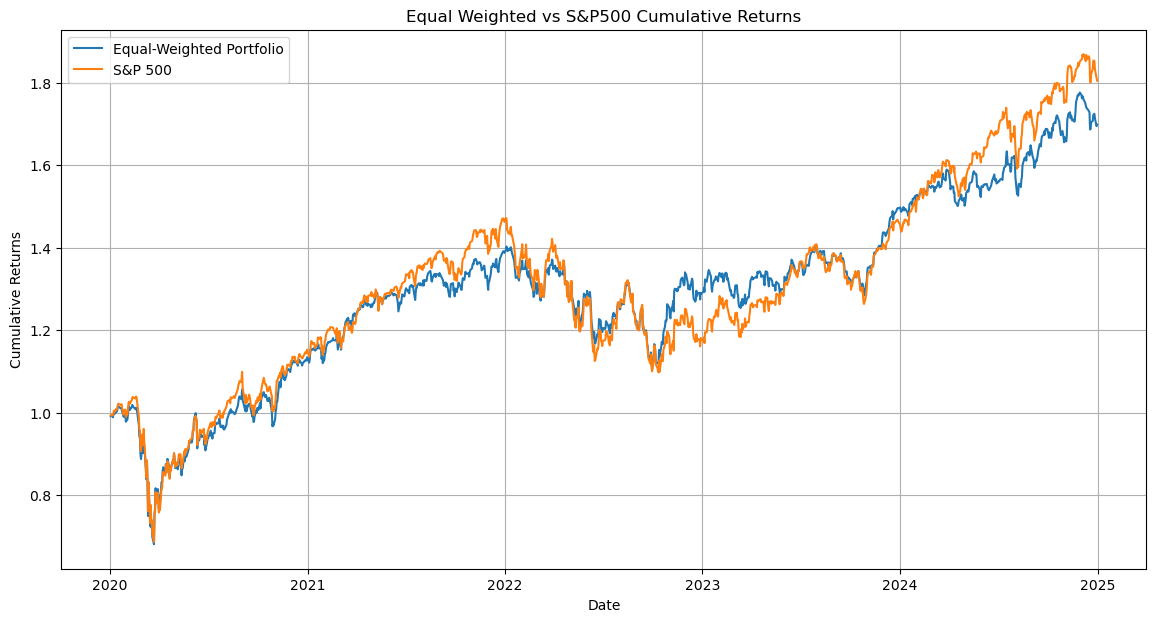

In [8]:

# Visualize results
plt.figure(figsize=(14, 7))
plt.plot(equal_weighted_cumulative_returns, label='Equal-Weighted Portfolio')
plt.plot(sp500_cumulative_returns, label='S&P 500')
# plt.plot(nasdaq_cumulative_returns, label='NASDAQ 100')

plt.legend()
plt.xlabel('Date')
plt.ylabel('Cumulative Returns')
plt.title('Equal Weighted vs S&P500 Cumulative Returns')
plt.grid()

plt.show()


# Garch Model for Volatility Forecasting

In [9]:
garch_volatility = pd.DataFrame()

# We estimate time-varying asset volatility using rolling GARCH(1,2)
for stock in tqdm(returns.columns):
    stock_returns = returns[stock] * 100  # Scale to percentage returns

    rolling_vols = []
    rolling_dates = []

    stock_dates = stock_returns.index
    start_date = pd.Timestamp('2020-01-01')
    start_idx = stock_dates.get_indexer([start_date], method='backfill')[0]

    for i in range(start_idx, len(stock_returns)):
        train_returns_garch = stock_returns.iloc[:i]

        model = arch_model(
            train_returns_garch,
            mean="Zero",
            vol="Garch",
            p=1, # We use (1,2) after testing various metrics 
            q=2,
            rescale=False
        )

        model_fit = model.fit(disp='off')
        forecast = model_fit.forecast(horizon=1)
        sigma = np.sqrt(forecast.variance.values[-1, 0])

        rolling_vols.append(sigma)
        rolling_dates.append(stock_returns.index[i])

    garch_volatility[stock] = pd.Series(rolling_vols, index=rolling_dates)



100%|██████████| 27/27 [07:41<00:00, 17.11s/it]


In [10]:
# Get Covariance Matrix
print(garch_volatility.index.min(), garch_volatility.index.max())

# Only keep returns after 2020
returns_post_2020 = returns.loc['2020-01-01':]

# Rolling correlation
rolling_window = 60
rolling_correlations = returns_post_2020.rolling(rolling_window).corr()


2020-01-02 00:00:00 2024-12-31 00:00:00


In [11]:
# Construct dynamic covariance matrices

dynamic_cov_matrices = {}

for date in tqdm(garch_volatility.index):
    if date not in rolling_correlations.index.get_level_values(0):
        continue

    corr_matrix = rolling_correlations.loc[date]
    volatilities = garch_volatility.loc[date]

    cov_matrix = corr_matrix.copy()
    for i in corr_matrix.columns:
        for j in corr_matrix.columns:
            cov_matrix.loc[i, j] = corr_matrix.loc[i, j] * volatilities[i] * volatilities[j]

    dynamic_cov_matrices[date] = cov_matrix


100%|██████████| 1258/1258 [00:18<00:00, 68.58it/s]


# Long Sort Term Model for Return Forecasting

In [12]:


# def the LSTM training function

def train_lstm_model(train_prices, lookback=60, epochs=10):
    scaler = MinMaxScaler(feature_range=(0, 1))
    scaled_prices = scaler.fit_transform(train_prices.reshape(-1, 1))

    X, y = [], []
    for i in range(lookback, len(scaled_prices)):
        X.append(scaled_prices[i-lookback:i, 0])
        y.append(scaled_prices[i, 0])

    X, y = np.array(X), np.array(y)
    X = np.reshape(X, (X.shape[0], lookback, 1))
    
    # def the updated model with best hyperparameters
    model = Sequential([
        LSTM(128, return_sequences=True, input_shape=(X.shape[1], 1)),  # 128 LSTM units
        Dropout(0.1),  # Dropout rate of 0.1
        LSTM(128),  # Second LSTM layer with 128 units
        Dropout(0.1),  # Dropout rate of 0.1
        Dense(1)  # Output layer
    ])
    
    # compile  model with updated learning rate
    optimizer = Adam(learning_rate=0.01)  # set learning rate to 0.01
    model.compile(optimizer=optimizer, loss='mean_squared_error')
    
    model.summary()
    model.fit(X, y, epochs=2, batch_size=32, verbose=1)

    return model, scaler


In [13]:

# Train LSTM for all stocks
lstm_models = {}
lstm_scalers = {}
lookback_period = 60

for ticker in tickers:
    print(f"Training LSTM for {ticker}")
    train_prices = train_data[ticker].values
    model, scaler = train_lstm_model(train_prices, lookback=lookback_period, epochs=10)
    lstm_models[ticker] = model
    lstm_scalers[ticker] = scaler




Training LSTM for AAPL


/Applications/anaconda3/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 60, 128)        │        66,560 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 60, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 128)            │       131,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 198,273 (774.50 KB)

 Trainable params: 198,273 (774.50 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/2
117/117 ━━━━━━━━━━━━━━━━━━━━ 6s 44ms/step - loss: 0.0303
Epoch 2/2
117/117 ━━━━━━━━━━━━━━━━━━━━ 5s 45ms/step - loss: 5.0521e-04
Training LSTM for AMGN


/Applications/anaconda3/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_2 (LSTM)                   │ (None, 60, 128)        │        66,560 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 60, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_3 (LSTM)                   │ (None, 128)            │       131,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 198,273 (774.50 KB)

 Trainable params: 198,273 (774.50 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/2
117/117 ━━━━━━━━━━━━━━━━━━━━ 6s 47ms/step - loss: 0.1888
Epoch 2/2
117/117 ━━━━━━━━━━━━━━━━━━━━ 6s 47ms/step - loss: 6.7667e-04
Training LSTM for AXP


/Applications/anaconda3/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_4 (LSTM)                   │ (None, 60, 128)        │        66,560 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 60, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_5 (LSTM)                   │ (None, 128)            │       131,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 198,273 (774.50 KB)

 Trainable params: 198,273 (774.50 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/2
117/117 ━━━━━━━━━━━━━━━━━━━━ 6s 43ms/step - loss: 0.0775
Epoch 2/2
117/117 ━━━━━━━━━━━━━━━━━━━━ 5s 46ms/step - loss: 7.3241e-04
Training LSTM for BA


/Applications/anaconda3/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_6 (LSTM)                   │ (None, 60, 128)        │        66,560 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 60, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_7 (LSTM)                   │ (None, 128)            │       131,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 198,273 (774.50 KB)

 Trainable params: 198,273 (774.50 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/2
117/117 ━━━━━━━━━━━━━━━━━━━━ 6s 43ms/step - loss: 0.0376
Epoch 2/2
117/117 ━━━━━━━━━━━━━━━━━━━━ 5s 46ms/step - loss: 4.4510e-04
Training LSTM for CAT


/Applications/anaconda3/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_8 (LSTM)                   │ (None, 60, 128)        │        66,560 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ (None, 60, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_9 (LSTM)                   │ (None, 128)            │       131,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_9 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 198,273 (774.50 KB)

 Trainable params: 198,273 (774.50 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/2
117/117 ━━━━━━━━━━━━━━━━━━━━ 7s 46ms/step - loss: 0.1588
Epoch 2/2
117/117 ━━━━━━━━━━━━━━━━━━━━ 5s 45ms/step - loss: 0.0010
Training LSTM for CRM


/Applications/anaconda3/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_10 (LSTM)                  │ (None, 60, 128)        │        66,560 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_10 (Dropout)            │ (None, 60, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_11 (LSTM)                  │ (None, 128)            │       131,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_11 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 198,273 (774.50 KB)

 Trainable params: 198,273 (774.50 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/2
117/117 ━━━━━━━━━━━━━━━━━━━━ 6s 46ms/step - loss: 0.0967
Epoch 2/2
117/117 ━━━━━━━━━━━━━━━━━━━━ 6s 48ms/step - loss: 7.9757e-04
Training LSTM for CSCO


/Applications/anaconda3/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_12 (LSTM)                  │ (None, 60, 128)        │        66,560 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_12 (Dropout)            │ (None, 60, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_13 (LSTM)                  │ (None, 128)            │       131,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_13 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 198,273 (774.50 KB)

 Trainable params: 198,273 (774.50 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/2
117/117 ━━━━━━━━━━━━━━━━━━━━ 6s 43ms/step - loss: 0.0932
Epoch 2/2
117/117 ━━━━━━━━━━━━━━━━━━━━ 5s 46ms/step - loss: 6.6800e-04
Training LSTM for CVX


/Applications/anaconda3/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_14 (LSTM)                  │ (None, 60, 128)        │        66,560 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_14 (Dropout)            │ (None, 60, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_15 (LSTM)                  │ (None, 128)            │       131,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_15 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 198,273 (774.50 KB)

 Trainable params: 198,273 (774.50 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/2
117/117 ━━━━━━━━━━━━━━━━━━━━ 6s 43ms/step - loss: 0.0666
Epoch 2/2
117/117 ━━━━━━━━━━━━━━━━━━━━ 5s 46ms/step - loss: 0.0013
Training LSTM for DIS


/Applications/anaconda3/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_16 (LSTM)                  │ (None, 60, 128)        │        66,560 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_16 (Dropout)            │ (None, 60, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_17 (LSTM)                  │ (None, 128)            │       131,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_17 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 198,273 (774.50 KB)

 Trainable params: 198,273 (774.50 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/2
117/117 ━━━━━━━━━━━━━━━━━━━━ 6s 43ms/step - loss: 0.1871
Epoch 2/2
117/117 ━━━━━━━━━━━━━━━━━━━━ 6s 48ms/step - loss: 6.7959e-04
Training LSTM for GS


/Applications/anaconda3/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_9"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_18 (LSTM)                  │ (None, 60, 128)        │        66,560 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_18 (Dropout)            │ (None, 60, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_19 (LSTM)                  │ (None, 128)            │       131,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_19 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 198,273 (774.50 KB)

 Trainable params: 198,273 (774.50 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/2
117/117 ━━━━━━━━━━━━━━━━━━━━ 6s 45ms/step - loss: 0.2879
Epoch 2/2
117/117 ━━━━━━━━━━━━━━━━━━━━ 5s 46ms/step - loss: 0.0016
Training LSTM for HD


/Applications/anaconda3/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_10"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_20 (LSTM)                  │ (None, 60, 128)        │        66,560 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_20 (Dropout)            │ (None, 60, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_21 (LSTM)                  │ (None, 128)            │       131,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_21 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 198,273 (774.50 KB)

 Trainable params: 198,273 (774.50 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/2
117/117 ━━━━━━━━━━━━━━━━━━━━ 6s 43ms/step - loss: 0.0529
Epoch 2/2
117/117 ━━━━━━━━━━━━━━━━━━━━ 5s 44ms/step - loss: 5.7094e-04
Training LSTM for HON


/Applications/anaconda3/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_11"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_22 (LSTM)                  │ (None, 60, 128)        │        66,560 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_22 (Dropout)            │ (None, 60, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_23 (LSTM)                  │ (None, 128)            │       131,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_23 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 198,273 (774.50 KB)

 Trainable params: 198,273 (774.50 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/2
117/117 ━━━━━━━━━━━━━━━━━━━━ 6s 46ms/step - loss: 0.0702
Epoch 2/2
117/117 ━━━━━━━━━━━━━━━━━━━━ 5s 44ms/step - loss: 6.0593e-04
Training LSTM for IBM


/Applications/anaconda3/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_12"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_24 (LSTM)                  │ (None, 60, 128)        │        66,560 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_24 (Dropout)            │ (None, 60, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_25 (LSTM)                  │ (None, 128)            │       131,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_25 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_12 (Dense)                │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 198,273 (774.50 KB)

 Trainable params: 198,273 (774.50 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/2
117/117 ━━━━━━━━━━━━━━━━━━━━ 7s 46ms/step - loss: 0.2783
Epoch 2/2
117/117 ━━━━━━━━━━━━━━━━━━━━ 5s 45ms/step - loss: 0.0015
Training LSTM for INTC


/Applications/anaconda3/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_13"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_26 (LSTM)                  │ (None, 60, 128)        │        66,560 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_26 (Dropout)            │ (None, 60, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_27 (LSTM)                  │ (None, 128)            │       131,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_27 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 198,273 (774.50 KB)

 Trainable params: 198,273 (774.50 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/2
117/117 ━━━━━━━━━━━━━━━━━━━━ 6s 43ms/step - loss: 0.0346
Epoch 2/2
117/117 ━━━━━━━━━━━━━━━━━━━━ 5s 45ms/step - loss: 7.9056e-04
Training LSTM for JNJ


/Applications/anaconda3/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_14"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_28 (LSTM)                  │ (None, 60, 128)        │        66,560 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_28 (Dropout)            │ (None, 60, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_29 (LSTM)                  │ (None, 128)            │       131,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_29 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_14 (Dense)                │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 198,273 (774.50 KB)

 Trainable params: 198,273 (774.50 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/2
117/117 ━━━━━━━━━━━━━━━━━━━━ 6s 44ms/step - loss: 0.0488
Epoch 2/2
117/117 ━━━━━━━━━━━━━━━━━━━━ 5s 45ms/step - loss: 7.8180e-04
Training LSTM for JPM


/Applications/anaconda3/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_15"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_30 (LSTM)                  │ (None, 60, 128)        │        66,560 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_30 (Dropout)            │ (None, 60, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_31 (LSTM)                  │ (None, 128)            │       131,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_31 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_15 (Dense)                │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 198,273 (774.50 KB)

 Trainable params: 198,273 (774.50 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/2
117/117 ━━━━━━━━━━━━━━━━━━━━ 6s 44ms/step - loss: 0.0615
Epoch 2/2
117/117 ━━━━━━━━━━━━━━━━━━━━ 5s 45ms/step - loss: 9.1264e-04
Training LSTM for MCD


/Applications/anaconda3/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_32 (LSTM)                  │ (None, 60, 128)        │        66,560 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_32 (Dropout)            │ (None, 60, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_33 (LSTM)                  │ (None, 128)            │       131,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_33 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_16 (Dense)                │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 198,273 (774.50 KB)

 Trainable params: 198,273 (774.50 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/2
117/117 ━━━━━━━━━━━━━━━━━━━━ 6s 45ms/step - loss: 0.1644
Epoch 2/2
117/117 ━━━━━━━━━━━━━━━━━━━━ 5s 45ms/step - loss: 9.7107e-04
Training LSTM for MMM


/Applications/anaconda3/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_17"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_34 (LSTM)                  │ (None, 60, 128)        │        66,560 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_34 (Dropout)            │ (None, 60, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_35 (LSTM)                  │ (None, 128)            │       131,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_35 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_17 (Dense)                │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 198,273 (774.50 KB)

 Trainable params: 198,273 (774.50 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/2
117/117 ━━━━━━━━━━━━━━━━━━━━ 6s 43ms/step - loss: 0.3153
Epoch 2/2
117/117 ━━━━━━━━━━━━━━━━━━━━ 5s 44ms/step - loss: 8.4550e-04
Training LSTM for MRK


/Applications/anaconda3/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_18"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_36 (LSTM)                  │ (None, 60, 128)        │        66,560 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_36 (Dropout)            │ (None, 60, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_37 (LSTM)                  │ (None, 128)            │       131,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_37 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_18 (Dense)                │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 198,273 (774.50 KB)

 Trainable params: 198,273 (774.50 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/2
117/117 ━━━━━━━━━━━━━━━━━━━━ 6s 43ms/step - loss: 0.0926
Epoch 2/2
117/117 ━━━━━━━━━━━━━━━━━━━━ 5s 44ms/step - loss: 7.5496e-04
Training LSTM for MSFT


/Applications/anaconda3/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_19"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_38 (LSTM)                  │ (None, 60, 128)        │        66,560 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_38 (Dropout)            │ (None, 60, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_39 (LSTM)                  │ (None, 128)            │       131,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_39 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_19 (Dense)                │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 198,273 (774.50 KB)

 Trainable params: 198,273 (774.50 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/2
117/117 ━━━━━━━━━━━━━━━━━━━━ 6s 43ms/step - loss: 0.0290
Epoch 2/2
117/117 ━━━━━━━━━━━━━━━━━━━━ 5s 44ms/step - loss: 3.7262e-04
Training LSTM for NKE


/Applications/anaconda3/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_20"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_40 (LSTM)                  │ (None, 60, 128)        │        66,560 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_40 (Dropout)            │ (None, 60, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_41 (LSTM)                  │ (None, 128)            │       131,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_41 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_20 (Dense)                │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 198,273 (774.50 KB)

 Trainable params: 198,273 (774.50 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/2
117/117 ━━━━━━━━━━━━━━━━━━━━ 6s 43ms/step - loss: 0.2123
Epoch 2/2
117/117 ━━━━━━━━━━━━━━━━━━━━ 5s 44ms/step - loss: 0.0620
Training LSTM for PFE


/Applications/anaconda3/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_21"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_42 (LSTM)                  │ (None, 60, 128)        │        66,560 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_42 (Dropout)            │ (None, 60, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_43 (LSTM)                  │ (None, 128)            │       131,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_43 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_21 (Dense)                │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 198,273 (774.50 KB)

 Trainable params: 198,273 (774.50 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/2
117/117 ━━━━━━━━━━━━━━━━━━━━ 6s 43ms/step - loss: 0.1397
Epoch 2/2
117/117 ━━━━━━━━━━━━━━━━━━━━ 5s 44ms/step - loss: 7.7056e-04
Training LSTM for PG


/Applications/anaconda3/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_22"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_44 (LSTM)                  │ (None, 60, 128)        │        66,560 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_44 (Dropout)            │ (None, 60, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_45 (LSTM)                  │ (None, 128)            │       131,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_45 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_22 (Dense)                │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 198,273 (774.50 KB)

 Trainable params: 198,273 (774.50 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/2
117/117 ━━━━━━━━━━━━━━━━━━━━ 6s 42ms/step - loss: 0.0795
Epoch 2/2
117/117 ━━━━━━━━━━━━━━━━━━━━ 5s 43ms/step - loss: 4.7792e-04
Training LSTM for TRV


/Applications/anaconda3/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_23"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_46 (LSTM)                  │ (None, 60, 128)        │        66,560 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_46 (Dropout)            │ (None, 60, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_47 (LSTM)                  │ (None, 128)            │       131,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_47 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_23 (Dense)                │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 198,273 (774.50 KB)

 Trainable params: 198,273 (774.50 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/2
117/117 ━━━━━━━━━━━━━━━━━━━━ 6s 42ms/step - loss: 0.0768
Epoch 2/2
117/117 ━━━━━━━━━━━━━━━━━━━━ 5s 44ms/step - loss: 5.9362e-04
Training LSTM for UNH


/Applications/anaconda3/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_24"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_48 (LSTM)                  │ (None, 60, 128)        │        66,560 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_48 (Dropout)            │ (None, 60, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_49 (LSTM)                  │ (None, 128)            │       131,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_49 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_24 (Dense)                │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 198,273 (774.50 KB)

 Trainable params: 198,273 (774.50 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/2
117/117 ━━━━━━━━━━━━━━━━━━━━ 6s 42ms/step - loss: 0.0863
Epoch 2/2
117/117 ━━━━━━━━━━━━━━━━━━━━ 5s 43ms/step - loss: 6.2010e-04
Training LSTM for VZ


/Applications/anaconda3/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_25"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_50 (LSTM)                  │ (None, 60, 128)        │        66,560 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_50 (Dropout)            │ (None, 60, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_51 (LSTM)                  │ (None, 128)            │       131,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_51 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_25 (Dense)                │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 198,273 (774.50 KB)

 Trainable params: 198,273 (774.50 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/2
117/117 ━━━━━━━━━━━━━━━━━━━━ 6s 42ms/step - loss: 0.3085
Epoch 2/2
117/117 ━━━━━━━━━━━━━━━━━━━━ 5s 44ms/step - loss: 0.0011
Training LSTM for WMT


/Applications/anaconda3/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_26"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_52 (LSTM)                  │ (None, 60, 128)        │        66,560 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_52 (Dropout)            │ (None, 60, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_53 (LSTM)                  │ (None, 128)            │       131,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_53 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_26 (Dense)                │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 198,273 (774.50 KB)

 Trainable params: 198,273 (774.50 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/2
117/117 ━━━━━━━━━━━━━━━━━━━━ 6s 42ms/step - loss: 0.0722
Epoch 2/2
117/117 ━━━━━━━━━━━━━━━━━━━━ 5s 43ms/step - loss: 8.0631e-04


# Dynamic Optiomazation of Portfolio

In [16]:
# Find the nearest date in `available_dates` to `target_date`
def find_nearest_date(target_date, available_dates):
    pos = bisect_left(available_dates, target_date)
    if pos == 0:
        return available_dates[0]
    if pos == len(available_dates):
        return available_dates[-1]
    before = available_dates[pos - 1]
    after = available_dates[pos]
    if after - target_date < target_date - before:
        return after
    else:
        return before

In [15]:
# Initialize dynamic weights DataFrame
dynamic_weights_df = pd.DataFrame(index=sorted(dynamic_cov_matrices.keys())[lookback_period:], columns=tickers)

# Dynamic optimization loop
for date in tqdm(sorted(dynamic_cov_matrices.keys())[lookback_period:]):
    predicted_returns = []

    for ticker in tickers:
        recent_prices = full_data[ticker].loc[:date].iloc[-lookback_period:].values.reshape(-1, 1)

        scaler = lstm_scalers[ticker]
        model = lstm_models[ticker]

        recent_scaled = scaler.transform(recent_prices)
        recent_scaled = np.reshape(recent_scaled, (1, lookback_period, 1))

        predicted_price_scaled = model.predict(recent_scaled, verbose=0)
        predicted_price = scaler.inverse_transform(predicted_price_scaled)[0, 0]

        last_price = recent_prices[-1, 0]
        pred_return = (predicted_price - last_price) / last_price
        predicted_returns.append(pred_return)

    mean_predicted_returns = np.array(predicted_returns)

    # Get dynamic covariance matrix
    cov_matrix = dynamic_cov_matrices[date].values

    # Optimize dynamic portfolio weights
    optimized_weights = maximize_sharpe_ratio(mean_predicted_returns, cov_matrix)

    # Store dynamic weights
    dynamic_weights_df.loc[date] = optimized_weights

  0%|          | 0/1198 [00:00<?, ?it/s]

100%|██████████| 1198/1198 [39:10<00:00,  1.96s/it]   


In [17]:

portfolio_dynamic_returns = []

dates = dynamic_weights_df.index
for i in range(len(dates)-1):
    current_date = dates[i]
    next_date = dates[i+1]

    daily_returns = returns.loc[next_date]
    daily_weights = dynamic_weights_df.loc[current_date].values

    portfolio_return = np.dot(daily_returns, daily_weights)
    portfolio_dynamic_returns.append(portfolio_return)

portfolio_dynamic_returns = pd.Series(portfolio_dynamic_returns, index=dates[1:])
dynamic_cumulative_returns = (1 + portfolio_dynamic_returns).cumprod()



# Results Analysis

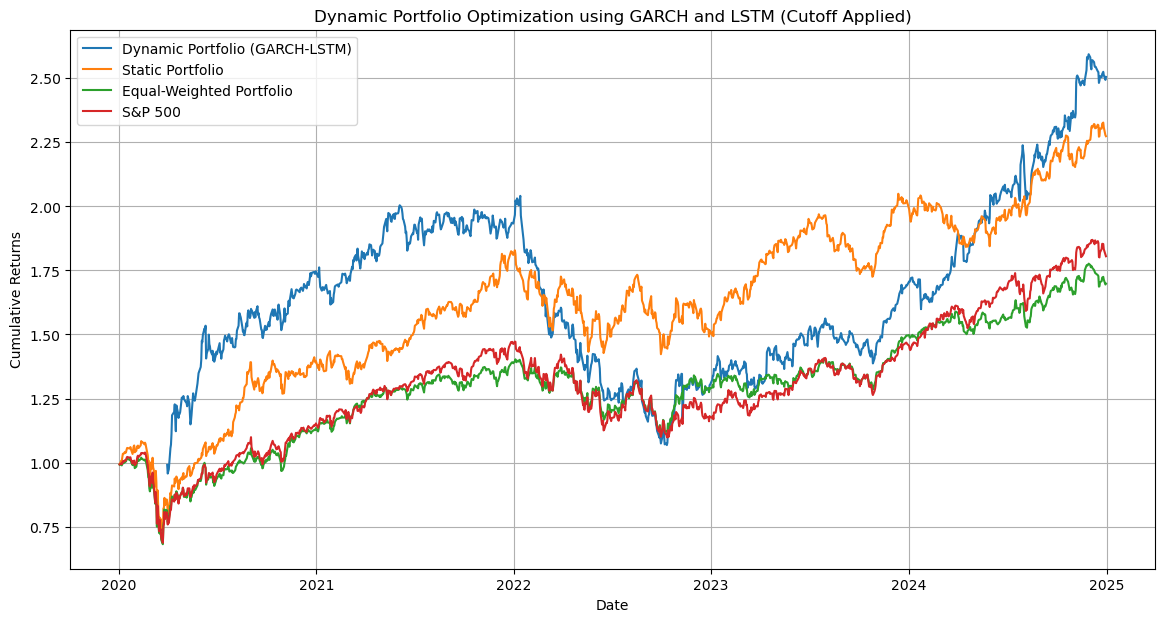

In [ ]:
# Ensure other portfolios also stop at the custom cutoff date
realistic_static_cumulative_returns = realistic_static_cumulative_returns.loc[:]
equal_weighted_cumulative_returns = equal_weighted_cumulative_returns.loc[:]
sp500_cumulative_returns = sp500_cumulative_returns.loc[:]
nasdaq_cumulative_returns = nasdaq_cumulative_returns.loc[:]

# Visualize results
plt.figure(figsize=(14, 7))
plt.plot(dynamic_cumulative_returns, label='Dynamic Portfolio (GARCH-LSTM)')
plt.plot(realistic_static_cumulative_returns, label='Static Portfolio')
plt.plot(equal_weighted_cumulative_returns, label='Equal-Weighted Portfolio')
plt.plot(sp500_cumulative_returns, label='S&P 500')
# plt.plot(nasdaq_cumulative_returns, label='NASDAQ 100')

plt.legend()
plt.xlabel('Date')
plt.ylabel('Cumulative Returns')
plt.title('Dynamic Portfolio Optimization using GARCH and LSTM (Cutoff Applied)')
plt.grid()
plt.show()


In [21]:
def compute_metrics(cumulative_returns, daily_returns, name, risk_free_rate=0.01):
    # Total Return Calculation
    total_return = cumulative_returns.iloc[-1] - 1
    
    # Annualized Return Calculation
    annualized_return = (cumulative_returns.iloc[-1] ** (252 / len(daily_returns))) - 1
    
    # Annualized Volatility Calculation
    annualized_volatility = daily_returns.std() * np.sqrt(252)
    
    # Sharpe Ratio Calculation
    sharpe_ratio = (annualized_return - risk_free_rate) / annualized_volatility
    
    # Sortino Ratio Calculation
    downside_returns = daily_returns[daily_returns < risk_free_rate]  # Returns below the risk-free rate
    downside_volatility = downside_returns.std() * np.sqrt(252)  # Annualized downside volatility
    
    # Ensure downside_volatility is a scalar value
    if isinstance(downside_volatility, pd.Series):
        downside_volatility = downside_volatility.item()  # Convert to scalar
    
    # Calculate Sortino Ratio
    sortino_ratio = (annualized_return - risk_free_rate) / downside_volatility if downside_volatility != 0 else np.nan
    
    # Maximum Drawdown Calculation
    max_drawdown = (cumulative_returns / cumulative_returns.cummax() - 1).min()

    # Return the results as a dictionary
    return {
        "Portfolio": name,
        "Total Return": float(total_return),
        "Annualized Return": float(annualized_return),
        "Volatility": float(annualized_volatility),
        "Sharpe Ratio": float(sharpe_ratio),
        "Sortino Ratio": float(sortino_ratio),
        "Max Drawdown": float(max_drawdown)
    }

In [22]:

# Compute metrics for each portfolio
metrics = []
metrics.append(compute_metrics(sp500_cumulative_returns, sp500_returns, "S&P 500"))
metrics.append(compute_metrics(realistic_static_cumulative_returns, realistic_static_portfolio_returns, "Static"))
metrics.append(compute_metrics(equal_weighted_cumulative_returns, equal_weighted_portfolio_returns, "Equal-Weighted Portfolio"))
#metrics.append(compute_metrics(nasdaq_cumulative_returns, nasdaq_returns, "NASDAQ 100"))
metrics.append(compute_metrics(dynamic_cumulative_returns, portfolio_dynamic_returns, "LSTM/Garch"))

# Display as DataFrame
metrics_df = pd.DataFrame(metrics)
metrics_df.set_index("Portfolio", inplace=True)

# Format output to display as percentages for returns and volatility, but Sharpe Ratio as decimal
metrics_df = metrics_df.style.format({
    "Total Return": "{:.2%}",
    "Annualized Return": "{:.2%}",
    "Volatility": "{:.2%}",
    "Sharpe Ratio": "{:.2f}",
    "Max Drawdown": "{:.2%}"
})
metrics_df


/var/folders/j9/6fx2fmbx4q96zsg213q_vm3w0000gn/T/ipykernel_21374/583790795.py:31: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  "Total Return": float(total_return),
/var/folders/j9/6fx2fmbx4q96zsg213q_vm3w0000gn/T/ipykernel_21374/583790795.py:32: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  "Annualized Return": float(annualized_return),
/var/folders/j9/6fx2fmbx4q96zsg213q_vm3w0000gn/T/ipykernel_21374/583790795.py:33: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  "Volatility": float(annualized_volatility),
/var/folders/j9/6fx2fmbx4q96zsg213q_vm3w0000gn/T/ipykernel_21374/583790795.py:34: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the futur

,Total Return,Annualized Return,Volatility,Sharpe Ratio,Sortino Ratio,Max Drawdown
Portfolio,,,,,,
S&P 500,80.54%,12.57%,21.34%,0.54,0.682451,-33.92%
Static,127.40%,17.90%,23.12%,0.73,0.950546,-33.37%
Equal-Weighted Portfolio,69.88%,11.21%,20.17%,0.51,0.646378,-33.15%
LSTM/Garch,150.56%,21.33%,24.25%,0.84,1.113826,-47.67%


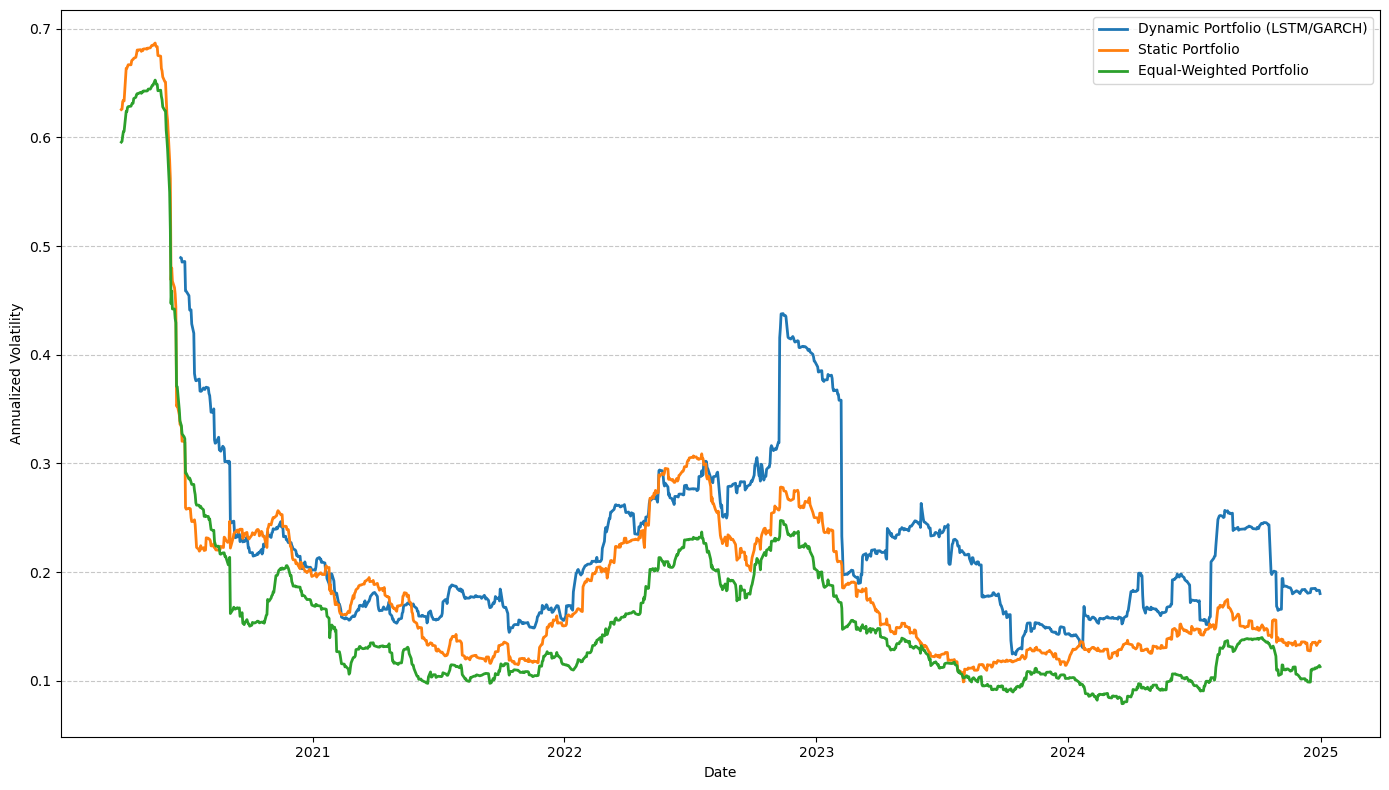

In [26]:
cutoff_date = '2025-01-01'
rolling_window = 60

static_vol = realistic_static_portfolio_returns.rolling(rolling_window).std() * np.sqrt(252)
equal_vol = equal_weighted_portfolio_returns.rolling(rolling_window).std() * np.sqrt(252)
dynamic_vol = portfolio_dynamic_returns.rolling(rolling_window).std() * np.sqrt(252)

static_vol = static_vol.loc[start_date:cutoff_date]
equal_vol = equal_vol.loc[start_date:cutoff_date]
dynamic_vol = dynamic_vol.loc[start_date:cutoff_date]

plt.figure(figsize=(14, 8))
plt.plot(dynamic_vol, label="Dynamic Portfolio (LSTM/GARCH)", linewidth=2)
plt.plot(static_vol, label="Static Portfolio", linewidth=2)
plt.plot(equal_vol, label="Equal-Weighted Portfolio", linewidth=2)

plt.xlabel("Date")
plt.ylabel("Annualized Volatility")
plt.legend()
plt.grid(True, axis="y", linestyle="--", alpha=0.7)
plt.tight_layout()
plt.show()


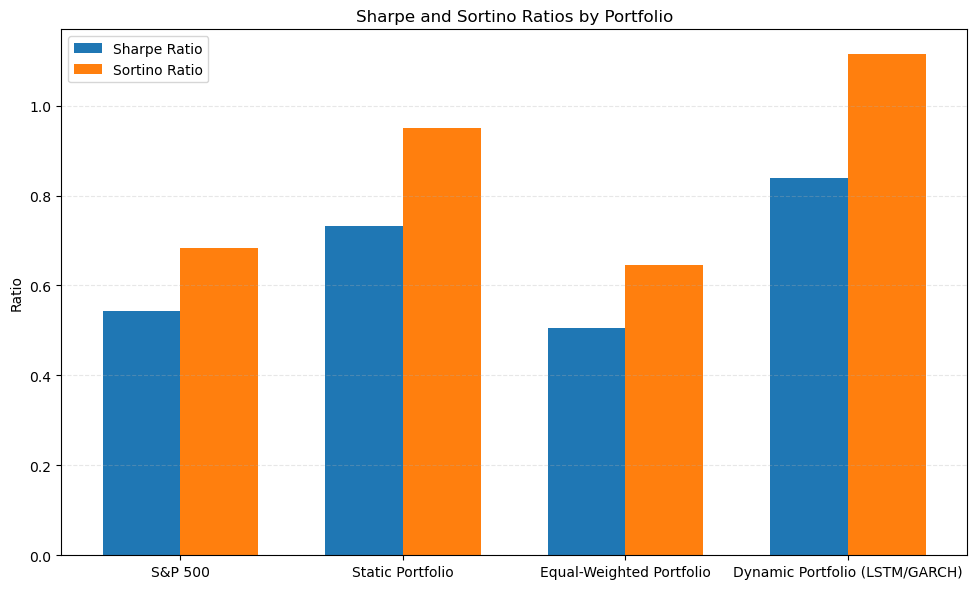

In [27]:
sharpe_ratios = metrics_df["Sharpe Ratio"]
sortino_ratios = metrics_df["Sortino Ratio"]

fig, ax = plt.subplots(figsize=(10, 6))
bar_width = 0.35
index = np.arange(len(metrics_df))

ax.bar(index, sharpe_ratios, bar_width, label="Sharpe Ratio")
ax.bar(index + bar_width, sortino_ratios, bar_width, label="Sortino Ratio")

ax.set_xticks(index + bar_width / 2)
ax.set_xticklabels(metrics_df.index)
ax.set_ylabel("Ratio")
ax.set_title("Sharpe and Sortino Ratios by Portfolio")
ax.legend()
ax.grid(True, axis="y", linestyle="--", alpha=0.3)

plt.tight_layout()
plt.show()


In [28]:
def compute_rolling_ratios(returns, window=63, risk_free_rate=0.01):
    rolling_sharpe = (returns.rolling(window).mean() - risk_free_rate) / (
        returns.rolling(window).std() * np.sqrt(252)
    )

    downside = returns.where(returns < risk_free_rate)
    rolling_sortino = (returns.rolling(window).mean() - risk_free_rate) / (
        downside.rolling(window).std() * np.sqrt(252)
    )

    return rolling_sharpe, rolling_sortino


In [33]:
rolling_sharpe_static, rolling_sortino_static = compute_rolling_ratios(realistic_static_portfolio_returns)
rolling_sharpe_equal, rolling_sortino_equal = compute_rolling_ratios(equal_weighted_portfolio_returns)
rolling_sharpe_dynamic, rolling_sortino_dynamic = compute_rolling_ratios(portfolio_dynamic_returns)

rolling_sharpe_static = rolling_sharpe_static.loc[start_date:cutoff_date]
rolling_sharpe_equal = rolling_sharpe_equal.loc[start_date:cutoff_date]
rolling_sharpe_dynamic = rolling_sharpe_dynamic.loc[start_date:cutoff_date]

rolling_sortino_static = rolling_sortino_static.loc[start_date:cutoff_date]
rolling_sortino_equal = rolling_sortino_equal.loc[start_date:cutoff_date]
rolling_sortino_dynamic = rolling_sortino_dynamic.loc[start_date:cutoff_date]


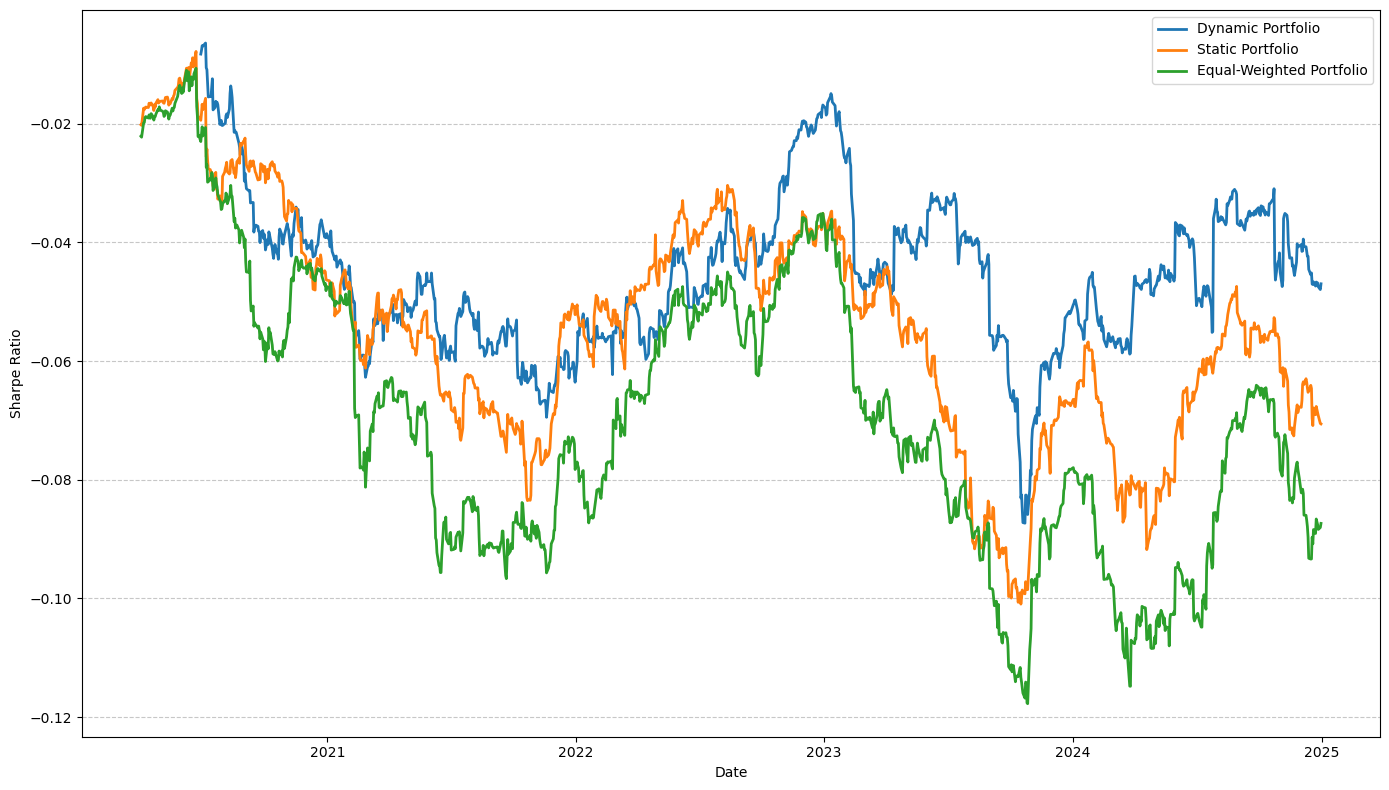

In [34]:
plt.figure(figsize=(14, 8))
plt.plot(rolling_sharpe_dynamic, label="Dynamic Portfolio", linewidth=2)
plt.plot(rolling_sharpe_static, label="Static Portfolio", linewidth=2)
plt.plot(rolling_sharpe_equal, label="Equal-Weighted Portfolio", linewidth=2)

plt.xlabel("Date")
plt.ylabel("Sharpe Ratio")
plt.legend()
plt.grid(True, axis="y", linestyle="--", alpha=0.7)
plt.tight_layout()
plt.show()


### Efficient Frontier Visualisation

In [42]:
mean_returns = test_mean_returns.values
cov_matrix = test_cov_matrix.values

num_portfolios = 10_000
results = np.zeros((3, num_portfolios))

for i in range(num_portfolios):
    weights = np.random.random(len(mean_returns))
    weights /= weights.sum()

    port_return = np.dot(weights, mean_returns)
    port_vol = np.sqrt(weights.T @ cov_matrix @ weights)
    sharpe = port_return / port_vol

    results[0, i] = port_vol
    results[1, i] = port_return
    results[2, i] = sharpe

max_sharpe_idx = np.argmax(results[2])
min_vol_idx = np.argmin(results[0])

# Annualized returns
static_ret = (realistic_static_cumulative_returns.iloc[-1] ** (252 / len(realistic_static_portfolio_returns))) - 1
equal_ret = (equal_weighted_cumulative_returns.iloc[-1] ** (252 / len(equal_weighted_portfolio_returns))) - 1
dynamic_ret = (dynamic_cumulative_returns.iloc[-1] ** (252 / len(portfolio_dynamic_returns))) - 1

# Annualized volatilities
static_vol = realistic_static_portfolio_returns.std() * np.sqrt(252)
equal_vol = equal_weighted_portfolio_returns.std() * np.sqrt(252)
dynamic_vol = portfolio_dynamic_returns.std() * np.sqrt(252)

# Efficient frontier (upper envelope)
vol_grid = np.linspace(results[0].min(), results[0].max(), 100)

frontier_returns = []
frontier_vols = []

for vol in vol_grid:
    mask = np.abs(results[0] - vol) < 0.002
    if np.any(mask):
        frontier_vols.append(vol)
        frontier_returns.append(results[1][mask].max())

frontier_vols = np.array(frontier_vols)
frontier_returns = np.array(frontier_returns)






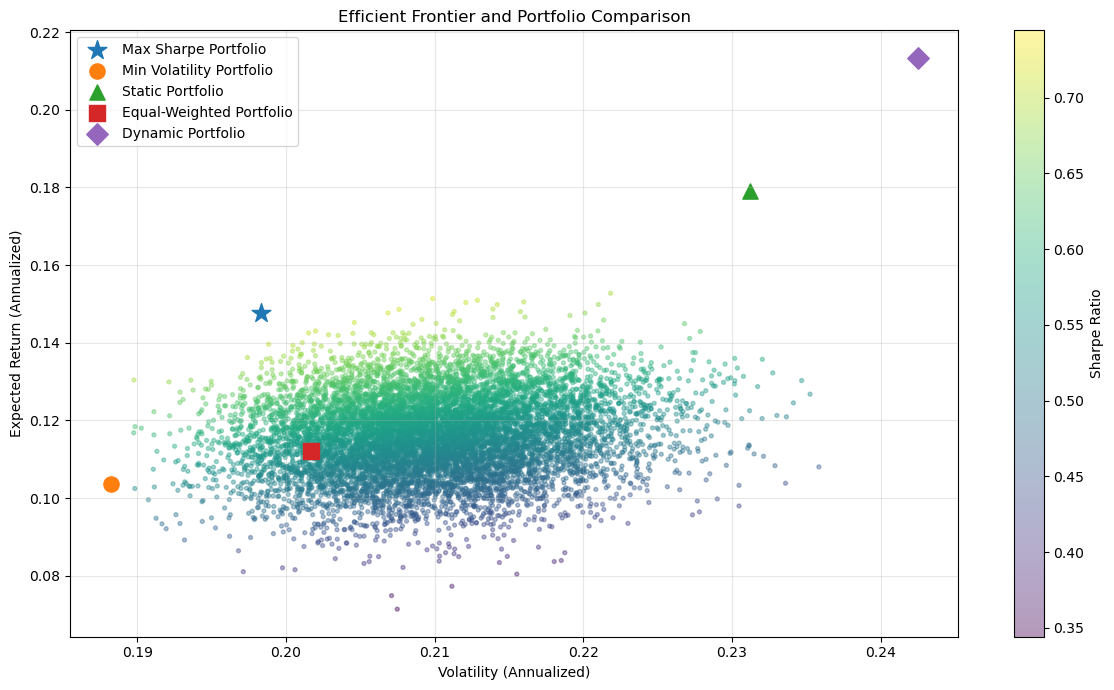

In [43]:

plt.figure(figsize=(12, 7))

sc = plt.scatter(
    results[0], results[1],
    c=results[2],
    cmap="viridis",
    s=8,
    alpha=0.4
)
plt.colorbar(sc, label="Sharpe Ratio")

plt.scatter(results[0, max_sharpe_idx], results[1, max_sharpe_idx],
            marker="*", s=200, label="Max Sharpe Portfolio")

plt.scatter(results[0, min_vol_idx], results[1, min_vol_idx],
            marker="o", s=120, label="Min Volatility Portfolio")

plt.scatter(static_vol, static_ret, marker="^", s=120, label="Static Portfolio")
plt.scatter(equal_vol, equal_ret, marker="s", s=120, label="Equal-Weighted Portfolio")
plt.scatter(dynamic_vol, dynamic_ret, marker="D", s=120, label="Dynamic Portfolio")

plt.xlabel("Volatility (Annualized)")
plt.ylabel("Expected Return (Annualized)")
plt.title("Efficient Frontier and Portfolio Comparison")
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()
